# Time Dilation by Example
Let's apply our knowledge of Special Relativity (SR) and General Relativity (GR) to predict the phenomenon of time dilation.

Special Relativity, which describes spacetime far from a significant gravity field, explains how a stationary observer perceives time passing slower for a moving observer when the relative velocity between them is very large.

General Relativity, which deals with gravity, explains how time slows down in proximity to a large gravitational acceleration.

The [wikipedia page for time dilation](https://en.wikipedia.org/wiki/Time_dilation) provides a derivation of these effects and a handy plot showing time dilation in Earth orbit. Let's try to recreate it.

![time dilation plot](./Time_Dilation_vs_Orbital_Height.png)

We can see there are two terms here, one that only depends on potential, and one that depends on the velocity.

The kinematic term (red) is negative---it is working to "slow down" the proper time with respect to cooridinate time by reducing the proper time's instant as velocity increases. Here, we're choosing the velocity required for a circular Earth orbit at each altitude. This is special relativity at work.

The potential, or gravitational, term (blue) is positive---it is working to "speed up" the proper time with respect to coordinate time by enlarging the proper time's instant as it leaves the gravity well. To be precise, a clock is slower for observers closer to the center of the gravity well. This is general relativity at work.

## Kinematic Dilation (Special Relativity)
Special Relativity states that the speed of light, $c$, is constant in all inertial reference frames. This leads to interesting consequences for spacetime.

Consider a coordinate frame with a space axis, $x$, and a time axis, $t$. For now let's assume that this coordinate frame is far from any gravity wells (we'll consider that later). Events are points in this coordinate frame with a time coordinate and a space coordinate. The length of a vector in this coordinate system, or the _spacetime interval_ between two events, represents the proper time measured with an inertial clock between the events.

Unlike linear spatial coordinates where the "grid" is square, spacetime coordinates are non-Euclidean, or not . The "grid" on the spacetime plot is made up of **hyperbolas** rather than lines. (Another example of non-Euclidean coordinates is spherical geometry, like latitude and longitude. And yes, [there is an xkcd comic about that]().)

The _Metric Equation_ describes this hyperbolic coordinate frame and lets us find a spacetime interval between events. ([Derivation](https://physics.unm.edu/Courses/Fields/Phys2310/Lectures/lecture27.pdf))
$$\Delta s^2 = \Delta t^2 - \Delta x^2$$

![spacetime is hyperbolic](./Spacetime_is_hyperbolic.png)

Let's rewrite the equation to be consistent with the variable names we've been using.
$$\Delta t_o^2 = \Delta t_c^2 - \Delta x^2$$

- $\Delta x$ is the distance traversed by a local observer of the event $e$ at some coordinate $(x,t)$.
- $\Delta t_c$ is the elapsed coordinate time to event $e$.
- $\Delta x / \Delta t_o$ is the speed of the moving observer relative to the coordinate frame, $v$.
- $\Delta t_o$, the length of a vector from the origin to $e$, is equal to the elapsed proper time according a local observer's inertial clock. This is also called the _spacetime interval_.

We want to relate the elapsed proper time $\Delta t_o$ to the elapsed coordinate time $\Delta t_c$. Special Relativity tells us that the speed of light, $c$, is constant in all inertial frames—this is the key to our solution. 

If we substitute our terms with equivalent definitions related to a pulse of light moving at $c$, we get
$$
\Big(c \frac{\Delta t_o}{2}\Big)^2 = \Big(c \frac{\Delta t_c}{2} \Big)^2 - \Big(v \frac{\Delta t_c}{2} \Big)^2, \quad v = \frac {\Delta x} {\Delta t_c}
$$
Solve for elapsed coordinate time using the locally observed proper time $\Delta t_o$ and the observer's speed in the coordinate frame. The relationship between proper time $t_o$ and coordinate time $t_c$ for special relativity depends only the relative speed between observers as the _Relativistic Factor_, $\gamma$, sometimes called the _Lorentz Factor_. Note that dilation from relative motion depends only on _relative speed between observers_ ($v$)---the acceleration of either observer has no bearing on kinematic dilation from special relativity.
$$
\gamma = \frac{\Delta t_c}{\Delta t_o} = \frac {1}{\sqrt{1 - v^2/c^2}}, \quad v = \frac {\Delta x} {\Delta t_c}
$$

We're not quite done: want to define "dilation" as _elapsed proper time per elapsed coordinate time_, or $\frac{\text{d}t_o}{\text{d}t_c}$. Let's reorganize the equation for convenience. 
$$
\frac{\text{d}t_o}{\text{d}t_c} = \sqrt{1 - v^2/c^2},\quad v = \frac {\text{d} x} {\text{d} t_c}
$$

There's a paradox here, did you catch it? Hint: _symmetry_ -> _reciprocity_ -> `spider_man_pointing.jpg`

> Given a certain frame of reference, and the "stationary" observer described earlier, if a second observer accompanied the "moving" clock, each of the observers would perceive the other's clock as ticking at a slower rate than their own local clock, due to them both perceiving the other to be the one that is in motion relative to their own stationary frame of reference.
>
> Common sense would dictate that, if the passage of time has slowed for a moving object, said object would observe the external world's time to be correspondingly sped up. Counterintuitively, special relativity predicts the opposite. When two observers are in motion relative to each other, each will measure the other's clock slowing down, in concordance with them being in motion relative to the observer's frame of reference. 

In the end this is a matter of perspective. So long as we are consistent and careful when comparing inertial frames, everything will be alright. 😌

## Gravitational Dilation (General Relativity)
General Relativity states that massive objects warp spacetime around them, and the intensity of gravitational potential obeys the inverse square law. 

$$g = \frac{G M_\oplus m}{r}$$

where:
* $g$ is the acceleration due to gravity,
* $G$ is the gravitational constant,
* $M_\oplus$ is the mass of Earth,
* $m$ is the mass of the observer,
* $r$ is the distance from the center of Earth to an observer.


Consider two observers exploring extreme elevations on Earth: Observer A is at sea level and their twin, Observer B rides a hot air balloon about $1\ km$ directly above them. The distance from the center of the Earth to Observer A and Observer B is $r_A$ and $r_B$, respectively.
 
Unlike the dilation from special relativity and kinematic motion, dilation from gravity is clearly _not_ symmetric. Both observers can agree with certainty that $r_A < r_B$, so $g_A$ must be larger than $g_B$. There is no perspective paradox here.

Relativity is still a function of speed here, but we can use the Law of Conservation of Energy to translate the gravitational potential in terms of velocity. The _escape velocity_, $v_e$, is the speed necessary to cancel out the gravitational potential energy, $U$.
$$U = \frac{G M_\oplus m}{r}$$
$$K = \frac{1}{2} m v^2$$
$$0 = U+K \quad -> \quad U = K$$
$$ \frac{1}{2} m v_e^2 = \frac{G M_\oplus m}{r}$$
$$v_e^2 = \frac{2GM_\oplus}{r}$$


Now we should compute time dilation compared to a coordinate time $t_c$.
$$
\frac{\text{d}t_o}{\text{d}t_c} = \sqrt{1 + \frac{v_e^2}{c^2}},\quad v_e^2 = \frac{2GM_\oplus}{r}
$$

where:
* $c$ is the speed of light,
* $v_e$ is the escape velocity, which relates to gravitational potential 

### Total (Net) Dilation
To get the total time dilation we add the kinematic and gravitational components.
$$
\frac{\text{d}t_o}{\text{d}t_c} = \sqrt{1 + \frac{v_e^2}{c^2} - \frac{v^2}{c^2}}, \quad v_e^2 = \frac{2GM_\oplus}{r}
$$

## Assumptions & Simplifications
We can make a few simplifications to the full equation in order to recreate the plot from Wikipedia.

* The only significant Newtonian gravitational potentials are from Earth for the selected orbits. (This is where we should look first if our predictions are way off.)
* The Earth is a sphere with a radius equal to the mean Earth radius, and mass is evenly distributed.
* All orbits under consideration are circular. Hence, there is zero radial component to velocity, and the magnitude of the tangential velocity component is exactly the speed required to achieve an orbit with zero eccentricity.
* All orbits are computed at the same latitude and longitude, so only altitude varies. We choose the coordinates that line up with the ECI frame so changing altitude corresponds to motion along $x$, exactly radial from Earth's center.
* Neglect atmospheric drag.

## Code

We'll use Python because it's quick and perfect for playing around like this.

* Astrodynamics and universal constants, let's use [astropy](https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants).
* Import [matplotlib](https://matplotlib.org/) for plotting, as is tradition.
* For math and vectors, we'll use good ol' [numpy](https://numpy.org/).

In [5]:
import astropy
import matplotlib.pyplot as plt
import numpy as np

Let's start by importing some constants.

| quantity | symbol | value |
|---|---|---|
| speed of light | $c$ | $299792458\ \text{m}/\text{s}$ |
| gravitational constant | $G$ | $6.6743 \times 10^{-11}\ \frac{\text{m}^3}{\text{kg}\ \text{s}^2}$ |
| Earth mass | $\text{M}_\oplus$ | $5.97216787\times 10^{24}\ \text{kg}$ |
| Nominal Earth radius | $\text{R}_\oplus$ | $6378100\ \text{m}$ |

In [6]:
from astropy.constants import c, G
from astropy.units.astrophys import M_earth, R_earth

Now let's make our x-axis of orbital altitudes.

In [7]:
from astropy import units as u
import numpy as np

altitudes = np.logspace(start=2, stop=6, num=1_000, base=10) * u.m
r = altitudes + 1 * u.astrophys.R_earth

### Compute the gravitational potential
Remember, we can express this in terms of energy per unit mass using our definition for escape velocity.
$$v_e^2 = \frac{2GM_\oplus}{r}$$

Before we continue, we should take a step back and ask ourselves if the calculations so far agree with our intuition.

We expect the gravitational potential to increase in magnitude exponentially as we get closer to a body. Is that what happens?

NameError: name 'potentials' is not defined

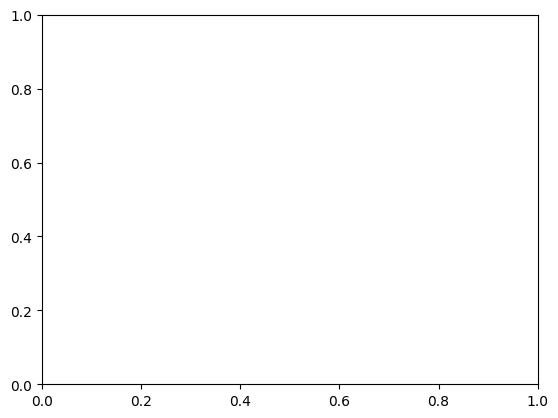

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for p in potentials:
    p.plot_contours(grid=(r,0,0), ax=ax)
ax.legend(labels)

Excellent, this is the shape we expected. As our $R$ value moves away from the center of Earth, the gravitational potential decreases and so too does the escape velocity.

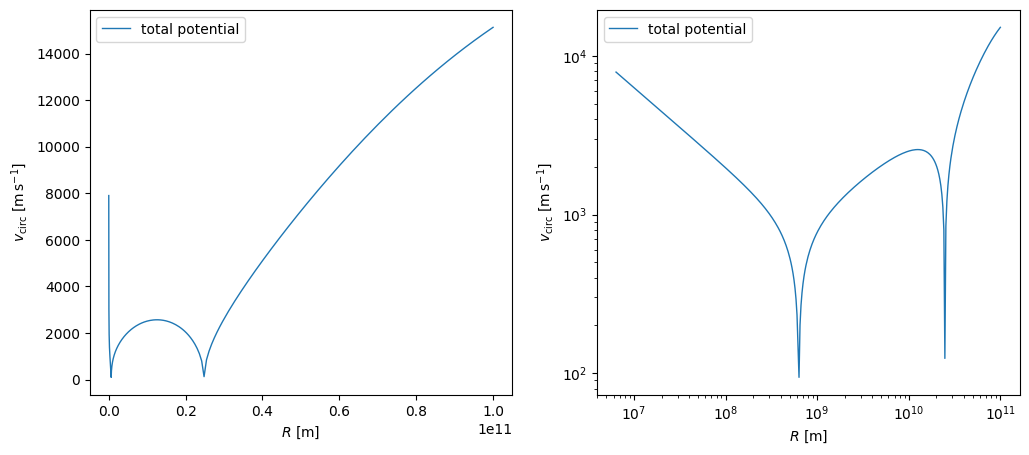

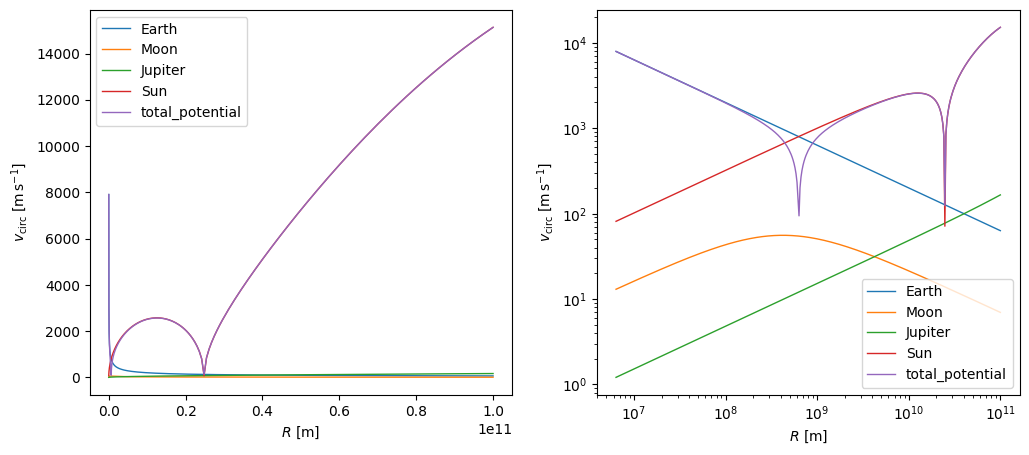

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
for axis, is_log_plot in zip(ax, [False, True]):
    axis = plot_rotation_curve(total_potential, r, loglog=is_log_plot, ax=axis)
    axis.legend(["total potential"])

fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
for p in potentials + [total_potential]:
    ax[0] = plot_rotation_curve(p, r, loglog=False, ax=ax[0])
ax[0].legend(labels + ["total_potential"])

for p in potentials + [total_potential]:
    ax[1] = plot_rotation_curve(p, r, loglog=True, ax=ax[1])
ax[1].legend(labels + ["total_potential"])

### Compute velocity for circular orbits at each altitude
We can use the potential energy definition to find the tangential velocity that would result in a perfectly circular orbit, too.
$$
something
$$

Let's represent the data in more familiar units. From the gravitational potential field, we can check what the gravitational acceleration would be at each point. We expect the acceleration to be $-9.81 \text{m}/\text{s}^2$ at Earth's surface ($r = R_{Earth}$) in the geocentric reference frame, and the speed of a circular orbit falls off as radius increases. Is that what happens?

Text(0, 0.5, 'velocity [$m / s$]')

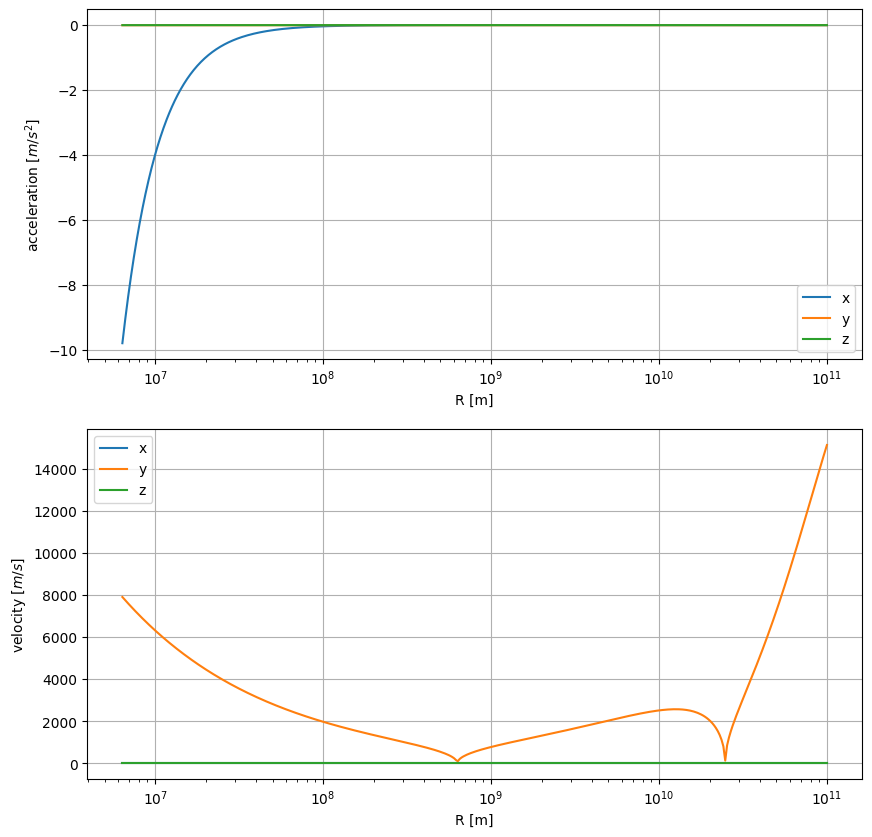

In [ ]:
dd_x, dd_y, dd_z = total_potential.acceleration(instants)
fig, ax = plt.subplots(figsize=(10,10), nrows=2, ncols=1)
ax[0].plot(r, dd_x, r, dd_y, r, dd_z)
ax[0].legend([f"{n}" for n in ["x", "y", "z"]])
ax[0].grid()
ax[0].set_xscale('log')
ax[0].set_xlabel(f"R [{r.unit}]")
ax[0].set_ylabel("acceleration [$m / s^2$]")
    
d_x, d_y, d_z = (instants.vel.d_x, instants.vel.d_y, instants.vel.d_z)
ax[1].plot(r, d_x, r, d_y, r, d_z)
ax[1].legend([f"{n}" for n in ["x", "y", "z"]])
ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_xlabel(f"R [{r.unit}]")
ax[1].set_ylabel("velocity [$m / s$]")

### Compute time dilation from each component

The shape looks right, but the y-axis doesn't match our reference (the pink line below). We have to convert $s/s$ to $\mu s/day$.

![time dilation plot](./Time_Dilation_vs_Orbital_Height.png)

In [ ]:
def to_us_per_day(dsec_per_sec):
    sec_per_day = 86_400
    us_per_sec = 1e6
    return dsec_per_sec * sec_per_day * us_per_sec

Text(0, 0.5, 'Time Dilation $\\Delta t_E / \\Delta t_c$ [s/s]')

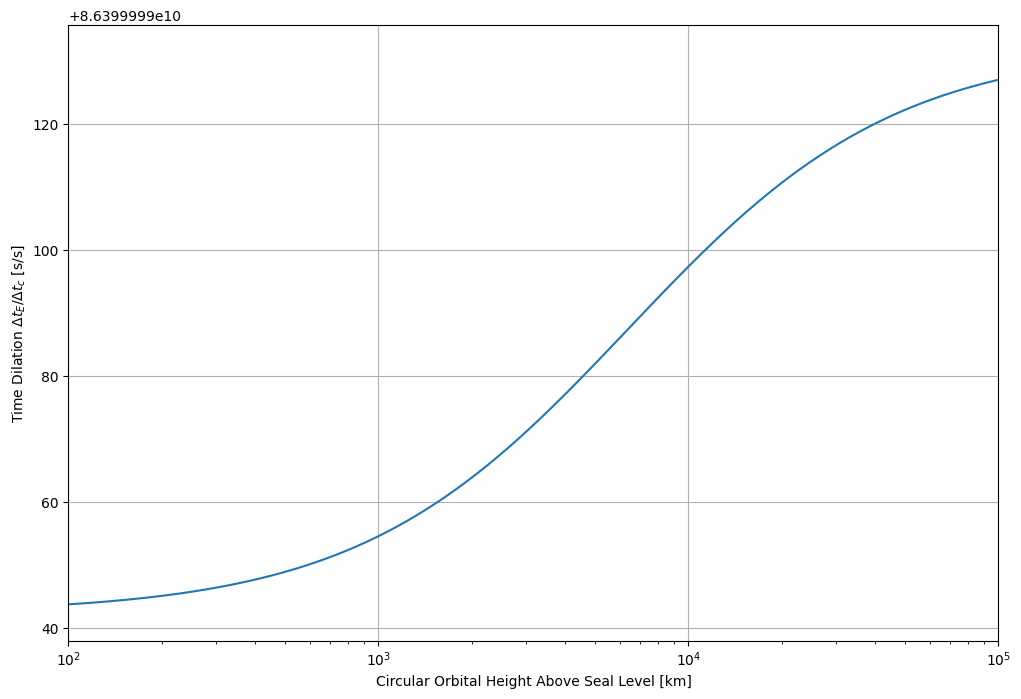

In [ ]:
converted_total_dilation = [to_us_per_day(time_dilation(i,total_potential)) for i in instants]
xunits=u.km
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(altitudes.to(xunits), converted_total_dilation)
ax.grid()
ax.set_xscale('log')
ax.set_xlim([1e2, 1e5])
ax.set_xlabel(f"Circular Orbital Height Above Seal Level [{xunits}]")
ax.set_ylabel("Time Dilation $\Delta t_E / \Delta t_c$ [s/s]")